In [2]:
import pandas as pd

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


### Create the dataset

In [3]:
discharges_train_df = pd.read_csv('data/train/discharge.csv.gz', compression='gzip')
discharges_valid_df = pd.read_csv('data/valid/discharge.csv.gz', compression='gzip')

In [4]:
print(len(discharges_train_df))
print(len(discharges_valid_df))

68785
14719


In [5]:
discharges_train_df.head()

,note_id,subject_id,hadm_id,note_type,note_seq,charttime,storetime,text
0,10000032-DS-22,10000032,22841357,DS,22,2180-06-27 00:00:00,2180-07-01 10:15:00,\nName: ___ Unit No: _...
1,10000117-DS-21,10000117,22927623,DS,21,2181-11-15 00:00:00,2181-11-15 15:04:00,\nName: ___ Unit No: ___\n...
2,10000935-DS-19,10000935,21738619,DS,19,2187-07-12 00:00:00,2187-07-12 14:01:00,\nName: ___ Unit No: ___...
3,10000935-DS-21,10000935,25849114,DS,21,2187-10-26 00:00:00,2187-10-27 15:36:00,\nName: ___ Unit No: ___...
4,10000980-DS-20,10000980,29654838,DS,20,2188-01-05 00:00:00,2188-01-06 20:49:00,\nName: ___ Unit No: ___\n \nAdmi...


In [6]:
discharges_valid_df.head()

,note_id,subject_id,hadm_id,note_type,note_seq,charttime,storetime,text
0,10000032-DS-21,10000032,22595853,DS,21,2180-05-07 00:00:00,2180-05-09 15:26:00,\nName: ___ Unit No: _...
1,10000764-DS-11,10000764,27897940,DS,11,2132-10-19 00:00:00,2132-10-19 18:50:00,\nName: ___ Unit No: ___\n \...
2,10002013-DS-8,10002013,24760295,DS,8,2160-07-12 00:00:00,2160-07-14 13:59:00,\nName: ___ Unit No: ___\n...
3,10002443-DS-15,10002443,21329021,DS,15,2183-10-20 00:00:00,2183-10-20 19:18:00,\nName: ___ Unit No: ...
4,10003019-DS-25,10003019,25179393,DS,25,2175-12-11 00:00:00,2175-12-11 18:24:00,\nName: ___. Unit No: ___\n \...


In [7]:
discharges_train_target_df = pd.read_csv('data/train/discharge_target.csv.gz', compression='gzip')
discharges_valid_target_df = pd.read_csv('data/valid/discharge_target.csv.gz', compression='gzip')

In [8]:
print(len(discharges_train_target_df))
print(len(discharges_valid_target_df))

68785
14719


In [9]:
discharges_train_target_df.head()

,note_id,hadm_id,discharge_instructions,brief_hospital_course,discharge_instructions_word_count,brief_hospital_course_word_count
0,15373895-DS-19,28448473,"Dear Mr. ___,\n\nIt was a pleasure taking care...",Mr. ___ was admitted from the emergency depart...,760,398
1,19045496-DS-24,22343752,You were admitted to the hospital after walkin...,___ year old female with past medical history ...,302,515
2,15071083-DS-16,24572540,you were hospitalized for gi bleeding that was...,"___ gentleman DM2, CAD s/p CABG, ischemic card...",73,579
3,11669075-DS-16,25889399,"Dear Mr. ___,\n\nWHY WERE YOU ADMITTED TO THE ...",Mr. ___ is a pleasant ___ y/o gentleman with a...,113,42
4,17164417-DS-7,24903173,Take your pain medicine as prescribed.\n\n¨ ...,Mr. ___ was admitted from the emergency depart...,226,167


In [10]:
discharges_valid_target_df.head()

,note_id,hadm_id,discharge_instructions,brief_hospital_course,discharge_instructions_word_count,brief_hospital_course_word_count
0,12730265-DS-17,21092119,"Dear Ms. ___, \n \nYou were admitted to __...",Ms. ___ is a ___ year old right-handed female ...,629,332
1,18070922-DS-18,22170434,"Mr. ___,\n\nYou were hospitalized for chest pa...",Mr. ___ ___ yo M with history of CHB s/p pacem...,41,79
2,15089072-DS-7,24182554,"Dear Ms. ___,\n\nYou were admitted to the hosp...",___ is an ___ yo woman with medical history of...,92,191
3,17304820-DS-15,21499821,Mr. ___\n\nIt was a pleasure taking care of yo...,The patient was admitted to the ___ Surgery Se...,732,407
4,10224816-DS-23,20339831,"Dear Mr. ___,\nYou were admitted to ___ after ...",CCU Course:\n___ with recent lumbar laminectom...,264,427


In [11]:
print(discharges_train_df['text'][0])

 
Name:  ___                     Unit No:   ___
 
Admission Date:  ___              Discharge Date:   ___
 
Date of Birth:  ___             Sex:   F
 
Service: MEDICINE
 
Allergies: 
Percocet
 
Attending: ___.
 
Chief Complaint:
abdominal fullness and discomfort
 
Major Surgical or Invasive Procedure:
___ diagnostic paracentesis
___ therapeutic paracentesis

 
History of Present Illness:
___ with HIV on HAART, COPD, HCV cirrhosis complicated by 
ascites and HE admitted with abdominal distention and pain. She 
was admitted to ___ for the same symptoms 
recently and had 3L fluid removed (no SBP) three days ago and 
felt better. Since discharge, her abdomen has become 
increasingly distended with pain. This feels similar to prior 
episodes of ascites.  
Her diuretics were recently decreased on ___ due to worsening 
hyponatremia 128 and hyperkalemia 5.1. Patient states she has 
been compliant with her HIV and diuretic medications but never 
filled out the lactulose prescription. She states

In [12]:
space_count = discharges_train_df['text'][0].count(" ")
print("Number of spaces in the string:", space_count)

Number of spaces in the string: 1901


In [13]:
discharges_train_target_count = discharges_train_target_df.duplicated(subset=['hadm_id']).sum()
discharges_valid_target_count = discharges_valid_target_df.duplicated(subset=['hadm_id']).sum()
print("Number of duplicate hadm_id in train:", discharges_train_target_count)
print("Number of duplicate hadm_id in valid:", discharges_valid_target_count)

Number of duplicate hadm_id in train: 0
Number of duplicate hadm_id in valid: 0


In [14]:
discharges_valid_df_count = discharges_valid_df.duplicated(subset=['hadm_id']).sum()
discharges_train_df_count = discharges_train_df.duplicated(subset=['hadm_id']).sum()
print("Number of duplicate hadm_id in train:", discharges_train_df_count)
print("Number of duplicate hadm_id in valid:", discharges_valid_df_count)


Number of duplicate hadm_id in train: 0
Number of duplicate hadm_id in valid: 0


In [15]:
combined_discharge_train_df = pd.merge(discharges_train_df[['hadm_id', 'text']],
                                discharges_train_target_df[['hadm_id', 'discharge_instructions', 'brief_hospital_course']],
                                on='hadm_id',
                                how='inner')

In [16]:
len(combined_discharge_train_df)

68785

In [17]:
combined_discharge_train_df.head()

,hadm_id,text,discharge_instructions,brief_hospital_course
0,22841357,\nName: ___ Unit No: _...,"Dear ___,\n\n___ was a pleasure to take care o...","___ with HIV on HAART, HCV cirrhosis with asci..."
1,22927623,\nName: ___ Unit No: ___\n...,"Dear Ms. ___,\n\nYou were hospitalized at ___....",Ms. ___ is a ___ with history of GERD who pres...
2,21738619,\nName: ___ Unit No: ___...,"Dear ___, \n\n___ were seen in the ED for ongo...",___ Female with PMH significant for depression...
3,25849114,\nName: ___ Unit No: ___...,"Dear Ms. ___,\nIt was a pleasure taking part i...",Ms. ___ is a ___ with metastatic cancer of unk...
4,29654838,\nName: ___ Unit No: ___\n \nAdmi...,"Dear Ms. ___, \n\nYou were admitted for shortn...","___ woman with h/o hypertension, hypelipidemia..."


In [18]:
print(combined_discharge_train_df['text'][2])

 
Name:  ___                   Unit No:   ___
 
Admission Date:  ___              Discharge Date:   ___
 
Date of Birth:  ___             Sex:   F
 
Service: MEDICINE
 
Allergies: 
Sulfa (Sulfonamide Antibiotics) / Codeine / Bactrim
 
Attending: ___
 
Chief Complaint:
nausea, vomiting, cough
 
Major Surgical or Invasive Procedure:
none

 
History of Present Illness:
___ female, with past medical history significant for 
depression, hyperlipidemia, Hysterectomy, B12 deficiency, back 
pain, carcinoid, cervical DJD, depression, hyperlipidemia, 
osteoarthritis, and history of Exploratory laparotomy, lysis of 
adhesions, and small bowel resection with enteroenterostomy for 
a high grade SBO ___ who presents with nausea, vomiting, 
weakness x 2 weeks. She has been uable to tolerate PO liquids, 
and solids. Had similar presentation ___ for high grade SBO. 
Denies passing flatus today. However reports having last normal 
bowel movement this AM, without hematochezia, melena. Also 
reporting sub

In [19]:
print(combined_discharge_train_df['discharge_instructions'][0])

Dear ___,

___ was a pleasure to take care of you at ___ 
___. You were admitted with abdominal fullness and 
pain from your ascites. You had a diagnostic and therapeutic 
paracentesis with 4.3 L removed. Your spironolactone was 
discontinued because your potassium was high. Your lasix was 
increased to 40mg daily. You are scheduled for another 
paracentesis on ___ prior to your other appointments that day. 
Please call tomorrow to find out the time of the paracentesis. 
Please continue to follow a low sodium diet and fluid 
restriction. You should call your liver doctor or return to the 
emergency room if you have abdominal pain, fever, chills, 
confusion, or other concerning symptoms.

Sincerely,
Your ___ medical team


In [20]:
print(combined_discharge_train_df['brief_hospital_course'][0])

___ with HIV on HAART, HCV cirrhosis with ascites and HE, h/o 
IVDU, COPD, bipolar disorder presents with abdominal discomfort 
due to ___ ascites.  
 
# ASCITES. Now diuretic refractory given last tap was three days 
ago with 3L removed and she has already built up moderate 
ascites. Infectious workup negative, with CXR clear, UA 
contaminated but not grossly positive so will f/u culture, 
diagnostic para with only 225 WBC, RUQ US with no PV thrombus. 
Compliant with diuretics but not following low sodium diet or 
fluid restriction. Dr. ___ discussed possible TIPS in 
the office but due to lung disease, that was on hold pending 
further cardiac evaluation. Diuretics were recently decreased 
due to hyponatremia and hyperkalemia. Held spironolactone for 
now due to K 5.2 and increased lasix 20 -> 40. No evidence of 
severe hyponatremia (Na<120) or renal failure Cr>2.0 to stop 
diuretics at present. Diagnostic paracentesis negative for 
infection. Ascitic total protein 0.3 so warrants SB

In [21]:
combined_discharge_valid_df = pd.merge(discharges_valid_df[['hadm_id', 'text']],
                                discharges_valid_target_df[['hadm_id', 'discharge_instructions', 'brief_hospital_course']],
                                on='hadm_id',
                                how='inner')

In [22]:
len(combined_discharge_valid_df)

14719

In [23]:
combined_discharge_df = pd.concat([combined_discharge_train_df, combined_discharge_valid_df], ignore_index=True)

In [24]:
len(combined_discharge_df)

83504

In [25]:
combined_discharge_df.head()

,hadm_id,text,discharge_instructions,brief_hospital_course
0,22841357,\nName: ___ Unit No: _...,"Dear ___,\n\n___ was a pleasure to take care o...","___ with HIV on HAART, HCV cirrhosis with asci..."
1,22927623,\nName: ___ Unit No: ___\n...,"Dear Ms. ___,\n\nYou were hospitalized at ___....",Ms. ___ is a ___ with history of GERD who pres...
2,21738619,\nName: ___ Unit No: ___...,"Dear ___, \n\n___ were seen in the ED for ongo...",___ Female with PMH significant for depression...
3,25849114,\nName: ___ Unit No: ___...,"Dear Ms. ___,\nIt was a pleasure taking part i...",Ms. ___ is a ___ with metastatic cancer of unk...
4,29654838,\nName: ___ Unit No: ___\n \nAdmi...,"Dear Ms. ___, \n\nYou were admitted for shortn...","___ woman with h/o hypertension, hypelipidemia..."


In [26]:
import re

combined_discharge_df['input_original_text'] = combined_discharge_df['text'].apply(lambda x: re.sub(r'Brief Hospital Course:\s*\n{0,2}(.*?)(?=\n\s*\n{0,2}\s*[A-Z_]+[^\n:]+:\n)', '', x, flags=re.DOTALL))
combined_discharge_df['input_original_text'] = combined_discharge_df['input_original_text'].apply(lambda x: re.sub(r'Discharge Instructions:\n(.*?)Followup Instruction', '', x, flags=re.DOTALL))


In [27]:
len(combined_discharge_df)

83504

In [28]:
combined_discharge_df.head()

,hadm_id,text,discharge_instructions,brief_hospital_course,input_original_text
0,22841357,\nName: ___ Unit No: _...,"Dear ___,\n\n___ was a pleasure to take care o...","___ with HIV on HAART, HCV cirrhosis with asci...",\nName: ___ Unit No: _...
1,22927623,\nName: ___ Unit No: ___\n...,"Dear Ms. ___,\n\nYou were hospitalized at ___....",Ms. ___ is a ___ with history of GERD who pres...,\nName: ___ Unit No: ___\n...
2,21738619,\nName: ___ Unit No: ___...,"Dear ___, \n\n___ were seen in the ED for ongo...",___ Female with PMH significant for depression...,\nName: ___ Unit No: ___...
3,25849114,\nName: ___ Unit No: ___...,"Dear Ms. ___,\nIt was a pleasure taking part i...",Ms. ___ is a ___ with metastatic cancer of unk...,\nName: ___ Unit No: ___...
4,29654838,\nName: ___ Unit No: ___\n \nAdmi...,"Dear Ms. ___, \n\nYou were admitted for shortn...","___ woman with h/o hypertension, hypelipidemia...",\nName: ___ Unit No: ___\n \nAdmi...


In [29]:
combined_discharge_df['input_original_text'][1]

" \nName:  ___                 Unit No:   ___\n \nAdmission Date:  ___              Discharge Date:   ___\n \nDate of Birth:  ___             Sex:   F\n \nService: MEDICINE\n \nAllergies: \nomeprazole\n \nAttending: ___.\n \nChief Complaint:\ndysphagia \n \nMajor Surgical or Invasive Procedure:\nUpper endoscopy ___\n\n \nHistory of Present Illness:\n ___ w/ anxiety and several years of dysphagia who p/w worsened \nforeign body sensation. \n\nShe describes feeling as though food gets stuck in her neck when \nshe eats. She put herself on a pureed diet to address this over \nthe last 10 days. When she has food stuck in the throat, she \nalmost feels as though she cannot breath, but she denies trouble \nbreathing at any other time. She does not have any history of \nfood allergies or skin rashes. \n \nIn the ED, initial vitals:  97.6  81  148/83  16  100% RA \nImaging showed: CXR showed a prominent esophagus\nConsults: GI was consulted.\n\nPt underwent EGD which showed a normal appearing e

In [30]:
print(combined_discharge_df['text'][0])

 
Name:  ___                     Unit No:   ___
 
Admission Date:  ___              Discharge Date:   ___
 
Date of Birth:  ___             Sex:   F
 
Service: MEDICINE
 
Allergies: 
Percocet
 
Attending: ___.
 
Chief Complaint:
abdominal fullness and discomfort
 
Major Surgical or Invasive Procedure:
___ diagnostic paracentesis
___ therapeutic paracentesis

 
History of Present Illness:
___ with HIV on HAART, COPD, HCV cirrhosis complicated by 
ascites and HE admitted with abdominal distention and pain. She 
was admitted to ___ for the same symptoms 
recently and had 3L fluid removed (no SBP) three days ago and 
felt better. Since discharge, her abdomen has become 
increasingly distended with pain. This feels similar to prior 
episodes of ascites.  
Her diuretics were recently decreased on ___ due to worsening 
hyponatremia 128 and hyperkalemia 5.1. Patient states she has 
been compliant with her HIV and diuretic medications but never 
filled out the lactulose prescription. She states

In [31]:
def extract_brief_text(text):
    Sex = re.findall(r'Sex:\s*\n{0,2}(.*?)\nService:', text, re.DOTALL)
    Allergies = re.findall(r'Allergies:\s*\n{0,2}(.*?)\nAttending:', text, re.DOTALL)
    Chief_Complaint = re.findall(r'Chief Complaint:\s*\n{0,2}(.*?)(?=\n\s*\n{0,2}\s*[A-Z_]+[^\n:]+:\n)', text, re.DOTALL)
    Major_Surgical_Procedures = re.findall(r'Major Surgical or Invasive Procedure:\s*\n{0,2}(.*?)(?=\n\s*\n{0,2}\s*[A-Z_]+[^\n:]+:\n)', text, re.DOTALL)
    History_of_Present_Illness = re.findall(r'History of Present Illness:\s*\n{0,2}(.*?)(?=\n\s*\n{0,2}\s*[A-Z_]+[^\n:]+:\n)', text, re.DOTALL)
    Past_Medical_History = re.findall(r'Past Medical History:\s*\n{0,2}(.*?)(?=\n\s*\n{0,2}\s*[A-Z_]+[^\n:]+:\n)', text, re.DOTALL)
    Social_History = re.findall(r'Social History:\s*\n{0,2}(.*?)(?=\n\s*\n{0,2}\s*[A-Z_]+[^\n:]+:\n)', text, re.DOTALL)
    Family_History = re.findall(r'Family History:\s*\n{0,2}(.*?)(?=\n\s*\n{0,2}\s*[A-Z_]+[^\n:]+:\n)', text, re.DOTALL)
    Physical_Exam = re.findall(r'Physical Exam:\s*\n{0,2}(.*?)(?=\n\s*\n{0,2}\s*[A-Z_]+[^\n:]+:\n)', text, re.DOTALL)
    Pertinent_Results = re.findall(r'Pertinent Results:\s*\n{0,2}(.*?)(?=\n\s*\n{0,2}\s*[A-Z_]+[^\n:]+:\n)', text, re.DOTALL)
    # Concatenate the extracted texts and return
    Sex_text = "Sex: \n" + ''.join(Sex)
    Allergies_text = "\nAllergies: \n" + ''.join(Allergies)
    Chief_Complaint_text = "\nChief Complaint: \n" + ''.join(Chief_Complaint)
    Major_Surgical_Procedures_text = "\n\nMajor Surgical or Invasive Procedure: \n" + ''.join(Major_Surgical_Procedures)
    History_of_Present_Illness_text = "\n\nHistory of Present Illness: \n" + ''.join(History_of_Present_Illness)
    Past_Medical_History_text = "\n\nPast Medical History: \n" + ''.join(Past_Medical_History)
    Social_History_text = "\n\nSocial History: \n" + ''.join(Social_History)
    Family_History_text = "\n\nFamily History: \n" + ''.join(Family_History)
    Physical_Exam_text = "\n\nPhysical Exam: \n" + ''.join(Physical_Exam)
    Pertinent_Results_text = "\n\nPertinent Results: \n" + ''.join(Pertinent_Results)
    return Sex_text + Allergies_text + Chief_Complaint_text + Major_Surgical_Procedures_text + History_of_Present_Illness_text + Past_Medical_History_text + Social_History_text + Family_History_text + Physical_Exam_text + Pertinent_Results_text
    
combined_discharge_df['input_hospital_text'] = combined_discharge_df['text'].apply(extract_brief_text)

In [32]:
combined_discharge_df.head()

,hadm_id,text,discharge_instructions,brief_hospital_course,input_original_text,input_hospital_text
0,22841357,\nName: ___ Unit No: _...,"Dear ___,\n\n___ was a pleasure to take care o...","___ with HIV on HAART, HCV cirrhosis with asci...",\nName: ___ Unit No: _...,Sex: \nF\n \nAllergies: \nPercocet\n \nChief C...
1,22927623,\nName: ___ Unit No: ___\n...,"Dear Ms. ___,\n\nYou were hospitalized at ___....",Ms. ___ is a ___ with history of GERD who pres...,\nName: ___ Unit No: ___\n...,Sex: \nF\n \nAllergies: \nomeprazole\n \nChief...
2,21738619,\nName: ___ Unit No: ___...,"Dear ___, \n\n___ were seen in the ED for ongo...",___ Female with PMH significant for depression...,\nName: ___ Unit No: ___...,Sex: \nF\n \nAllergies: \nSulfa (Sulfonamide A...
3,25849114,\nName: ___ Unit No: ___...,"Dear Ms. ___,\nIt was a pleasure taking part i...",Ms. ___ is a ___ with metastatic cancer of unk...,\nName: ___ Unit No: ___...,Sex: \nF\n \nAllergies: \nSulfa (Sulfonamide A...
4,29654838,\nName: ___ Unit No: ___\n \nAdmi...,"Dear Ms. ___, \n\nYou were admitted for shortn...","___ woman with h/o hypertension, hypelipidemia...",\nName: ___ Unit No: ___\n \nAdmi...,Sex: \nF\n \nAllergies: \nNo Known Allergies /...


In [47]:
print(combined_discharge_df['input_hospital_text'][106])

Sex: 
M
 
Allergies: 
Penicillins / NSAIDS (Non-Steroidal Anti-Inflammatory Drug) / 
erythromycin base
 
Chief Complaint: 
Fall, weakness, fatigue

Major Surgical or Invasive Procedure: 
None

History of Present Illness: 
Mr. ___ is a ___ year-old gentleman with history of CAD s/p DES, 
SSS s/p PPM, pAF on rivaroxaban in addition to Rai III CLL on 
ibrutinib and Stage IIIA NSGCT s/p radical orchiectomy and now 
on C2D7 of EP who presents with generalized weakness, a fall and 
abdominal discomfort. 

Mr. ___ was in his usual state of health until 2 days prior to 
admission when he began having generalized fatigue and malaise 
that has progressively worsened since then. On the day of 
admission he was walking back to the bathroom and felt his legs 
give out falling forward on his knees and hands. He denies loss
of consciousness, dizziness/lightheadedness, head strike. He is 
having some vague upper gastrointestinal upset over the past 2 
days along with some intermittent dyspnea. He deni

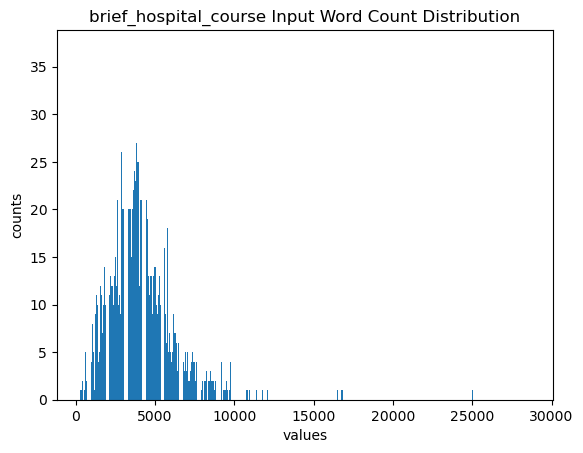

In [34]:
import matplotlib.pyplot as plt

value_counts = combined_discharge_df['input_hospital_text'].apply(len).value_counts()

plt.bar(value_counts.index, value_counts.values)
plt.xlabel('values')
plt.ylabel('counts')
plt.title('brief_hospital_course Input Word Count Distribution')
plt.show()

In [71]:
def extract_pertinent_text(text):
    Pertinent_Results = re.findall(r'Pertinent Results:\s*\n{0,2}(.*?)(?=\n\s*\n{0,2}\s*[A-Z_]+[^\n:]+:\n)', text, re.DOTALL)
    # Concatenate the extracted texts and return
    Pertinent_Results_text = "Pertinent Results: \n" + ''.join(Pertinent_Results)
    return Pertinent_Results_text

combined_discharge_pertinent_df = pd.DataFrame()  # Define the DataFrame
combined_discharge_pertinent_df['input_pertinent_text'] = combined_discharge_df['text'].apply(extract_pertinent_text)

In [76]:
print(combined_discharge_pertinent_df['input_pertinent_text'][106])

Pertinent Results: 
ADMISSION LABS
___ 07:00PM BLOOD WBC-52.2*# RBC-3.31* Hgb-8.8* Hct-26.8* 
MCV-81* MCH-26.6 MCHC-32.8 RDW-17.9* RDWSD-47.8* Plt ___
___ 07:00PM BLOOD Neuts-76* Bands-0 ___ Monos-1* 
Eos-1 Baso-0 ___ Myelos-0 NRBC-1* AbsNeut-39.67* 
AbsLymp-11.48* AbsMono-0.52 AbsEos-0.52 AbsBaso-0.00*
___ 07:00PM BLOOD Hypochr-NORMAL Anisocy-1+ Poiklo-1+ 
Macrocy-NORMAL Microcy-NORMAL Polychr-NORMAL Ovalocy-1+ Tear 
Dr-1+ Acantho-1+
___ 07:00PM BLOOD ___ PTT-29.1 ___
___ 07:00PM BLOOD Glucose-158* UreaN-26* Creat-1.3* Na-137 
K-3.8 Cl-100 HCO3-25 AnGap-16
___ 07:00PM BLOOD ALT-20 AST-17 AlkPhos-77 TotBili-<0.2
___ 07:00PM BLOOD Lipase-159*
___ 07:00PM BLOOD Albumin-3.8 Calcium-8.3* Phos-3.3 Mg-2.0
___ 05:11AM BLOOD TSH-4.0
___ 07:00PM BLOOD Lactate-1.8

MICROBIOLOGY

___ 10:30 pm Rapid Respiratory Viral Screen & Culture
      Source: Nasopharyngeal swab. 

   Respiratory Viral Culture (Pending): 

   Respiratory Viral Antigen Screen (Final ___: 
      Negative for Respiratory Viral A

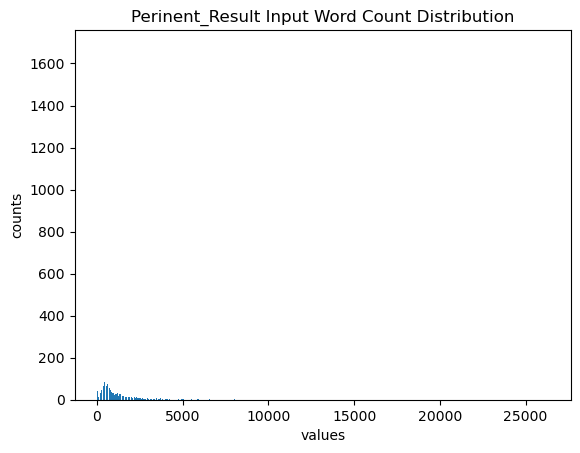

In [74]:
import matplotlib.pyplot as plt

value_counts = combined_discharge_pertinent_df['input_pertinent_text'].apply(len).value_counts()

plt.bar(value_counts.index, value_counts.values)
plt.xlabel('values')
plt.ylabel('counts')
plt.title('Perinent_Result Input Word Count Distribution')
plt.show()

In [63]:
def extract_instructions_text(text):
    Medications_on_Admission = re.findall(r'Medications on Admission:\n(.*?)Discharge Medications', text, re.DOTALL)
    Discharge_Medications = re.findall(r'Discharge Medications:\n(.*?)Discharge Disposition:', text, re.DOTALL)
    Discharge_Disposition = re.findall(r'Discharge Disposition:\n(.*?)Discharge Diagnosis:', text, re.DOTALL)
    Discharge_Diagnosis = re.findall(r'Discharge Diagnosis:\n(.*?)Discharge Condition:', text, re.DOTALL)
    Discharge_Condition = re.findall(r'Discharge Condition:\n(.*?)Discharge Instructions:', text, re.DOTALL)
    # Concatenate the extracted texts and return
    Medications_on_Admission_text = "Medications on Admission: \n" + ''.join(Medications_on_Admission)
    Discharge_Medications_text = "Discharge Medications: \n" + ''.join(Discharge_Medications)
    Discharge_Disposition_text = "Discharge Disposition: \n" + ''.join(Discharge_Disposition)
    Discharge_Diagnosis_text = "Discharge Diagnosis: \n" + ''.join(Discharge_Diagnosis)
    Discharge_Condition_text = "Discharge Condition: \n" + ''.join(Discharge_Condition)
    return "Summary of Brief House Course \n\n" + Medications_on_Admission_text + Discharge_Medications_text + Discharge_Disposition_text + Discharge_Diagnosis_text + Discharge_Condition_text

combined_discharge_df['input_instructions_text'] = combined_discharge_df['text'].apply(extract_instructions_text)

In [77]:
combined_discharge_df.head()

,hadm_id,text,discharge_instructions,brief_hospital_course,input_original_text,input_hospital_text,input_instructions_text
0,22841357,\nName: ___ Unit No: _...,"Dear ___,\n\n___ was a pleasure to take care o...","___ with HIV on HAART, HCV cirrhosis with asci...",\nName: ___ Unit No: _...,Sex: \nF\n \nAllergies: \nPercocet\n \nChief C...,Summary of Brief House Course \n\nMedications ...
1,22927623,\nName: ___ Unit No: ___\n...,"Dear Ms. ___,\n\nYou were hospitalized at ___....",Ms. ___ is a ___ with history of GERD who pres...,\nName: ___ Unit No: ___\n...,Sex: \nF\n \nAllergies: \nomeprazole\n \nChief...,Summary of Brief House Course \n\nMedications ...
2,21738619,\nName: ___ Unit No: ___...,"Dear ___, \n\n___ were seen in the ED for ongo...",___ Female with PMH significant for depression...,\nName: ___ Unit No: ___...,Sex: \nF\n \nAllergies: \nSulfa (Sulfonamide A...,Summary of Brief House Course \n\nMedications ...
3,25849114,\nName: ___ Unit No: ___...,"Dear Ms. ___,\nIt was a pleasure taking part i...",Ms. ___ is a ___ with metastatic cancer of unk...,\nName: ___ Unit No: ___...,Sex: \nF\n \nAllergies: \nSulfa (Sulfonamide A...,Summary of Brief House Course \n\nMedications ...
4,29654838,\nName: ___ Unit No: ___\n \nAdmi...,"Dear Ms. ___, \n\nYou were admitted for shortn...","___ woman with h/o hypertension, hypelipidemia...",\nName: ___ Unit No: ___\n \nAdmi...,Sex: \nF\n \nAllergies: \nNo Known Allergies /...,Summary of Brief House Course \n\nMedications ...


In [78]:
len(combined_discharge_df)

83504

In [79]:
# save the combined discharge dataframe
combined_discharge_df.to_csv('data/combined_discharge.csv.gz', index=False, compression='gzip')

In [68]:
print(combined_discharge_df['input_instructions_text'][3])

Summary of Brief House Course 

Medications on Admission: 
The Preadmission Medication list may be inaccurate and requires 
futher investigation.
1. Albuterol Inhaler ___ PUFF IH Q6H:PRN SOB 
2. BuPROPion 150 mg PO DAILY 
3. Gabapentin 300 mg PO HS 
4. Sertraline 200 mg PO DAILY 
5. traZODONE 100 mg PO HS:PRN sleep 
6. Ondansetron 4 mg PO Q8H:PRN nausea 
7. Bisacodyl 10 mg PO/PR DAILY:PRN constipation 
8. OxycoDONE (Immediate Release)  5 mg PO Q6H:PRN pain 
please hold for sedation, RR<10 
9. Enoxaparin Sodium 40 mg SC DAILY 

 
Discharge Medications: 
1. BuPROPion 150 mg PO DAILY 
2. Ondansetron 4 mg PO Q8H:PRN nausea 
3. TraMADOL (Ultram) 50 mg PO Q4H:PRN pain 
RX *tramadol 50 mg 1 tablet(s) by mouth every four (4) hours 
Disp #*60 Tablet Refills:*0
4. Senna 1 TAB PO BID:PRN constipation 
RX *sennosides [___] 8.6 mg 1 tablet by mouth twice a 
day Disp #*60 Tablet Refills:*0
5. Omeprazole 20 mg PO DAILY 
RX *omeprazole 20 mg 1 capsule,delayed ___ by 
mouth Daily Disp #*30 Capsule Refi

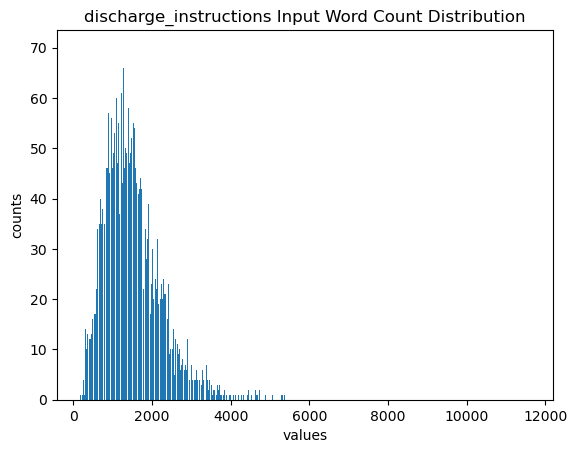

In [70]:
import matplotlib.pyplot as plt

value_counts = combined_discharge_df['input_instructions_text'].apply(len).value_counts()

plt.bar(value_counts.index, value_counts.values)
plt.xlabel('values')
plt.ylabel('counts')
plt.title('discharge_instructions Input Word Count Distribution')
plt.show()

In [3]:
combined_discharges_df = pd.read_csv('../data/combined_discharge.csv.gz', compression='gzip')

In [4]:
combined_discharges_df.head()

,hadm_id,text,discharge_instructions,brief_hospital_course,input_original_text,input_hospital_text,input_instructions_text
0,22841357,\nName: ___ Unit No: _...,"Dear ___,\n\n___ was a pleasure to take care o...","___ with HIV on HAART, HCV cirrhosis with asci...",\nName: ___ Unit No: _...,Sex: \nF\n \nAllergies: \nPercocet\n \nChief C...,Summary of Brief House Course \n\nMedications ...
1,22927623,\nName: ___ Unit No: ___\n...,"Dear Ms. ___,\n\nYou were hospitalized at ___....",Ms. ___ is a ___ with history of GERD who pres...,\nName: ___ Unit No: ___\n...,Sex: \nF\n \nAllergies: \nomeprazole\n \nChief...,Summary of Brief House Course \n\nMedications ...
2,21738619,\nName: ___ Unit No: ___...,"Dear ___, \n\n___ were seen in the ED for ongo...",___ Female with PMH significant for depression...,\nName: ___ Unit No: ___...,Sex: \nF\n \nAllergies: \nSulfa (Sulfonamide A...,Summary of Brief House Course \n\nMedications ...
3,25849114,\nName: ___ Unit No: ___...,"Dear Ms. ___,\nIt was a pleasure taking part i...",Ms. ___ is a ___ with metastatic cancer of unk...,\nName: ___ Unit No: ___...,Sex: \nF\n \nAllergies: \nSulfa (Sulfonamide A...,Summary of Brief House Course \n\nMedications ...
4,29654838,\nName: ___ Unit No: ___\n \nAdmi...,"Dear Ms. ___, \n\nYou were admitted for shortn...","___ woman with h/o hypertension, hypelipidemia...",\nName: ___ Unit No: ___\n \nAdmi...,Sex: \nF\n \nAllergies: \nNo Known Allergies /...,Summary of Brief House Course \n\nMedications ...


In [6]:
print(combined_discharges_df['input_hospital_text'][0])

Sex: 
F
 
Allergies: 
Percocet
 
Chief Complaint: 
abdominal fullness and discomfort

Major Surgical or Invasive Procedure: 
___ diagnostic paracentesis
___ therapeutic paracentesis

History of Present Illness: 
___ with HIV on HAART, COPD, HCV cirrhosis complicated by 
ascites and HE admitted with abdominal distention and pain. She 
was admitted to ___ for the same symptoms 
recently and had 3L fluid removed (no SBP) three days ago and 
felt better. Since discharge, her abdomen has become 
increasingly distended with pain. This feels similar to prior 
episodes of ascites.  
Her diuretics were recently decreased on ___ due to worsening 
hyponatremia 128 and hyperkalemia 5.1. Patient states she has 
been compliant with her HIV and diuretic medications but never 
filled out the lactulose prescription. She states she has had 
___ BMs daily at home. She has had some visual hallucinations 
and forgetfulness. Her appetite has been poor.  
In the ED, initial vitals were 98.9 88 116/88 18 97% 